In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from itertools import product
from survival_models import SurvivalModel
from lifelines import KaplanMeierFitter
import torch
import random
from tqdm import tqdm
import warnings
from collections import defaultdict

# Suppress specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in divide")

# Requirements:

Need to place the embedding pickle folders in `tts\{DS|L33}_embeddings` directory

The preprocessed pickled files are available to download from: https://cmu.box.com/s/lk5fbdv3lyzgw399gsrfkhl69g9719p7

There is a pickle file for each base embedding LM (e.g., `bert-base-uncased` or `DeepSeek-R1-Distill-Llama-70B`) and time threshold `t`. 
Each Pickle file is dict that has Case Report ID (PMCXXXXXXXX) as key and the value is a dict of `embedding` and `label`. 
`embedding` is vector of encoded textual time series until (and including) time threshold `t`.
`label` is a tuple of (`observed_time`, `event_indicator`) where `event_indicator` is 0 when right-censored and 1 when the patient has died.

# Start Experiments

In [2]:
random_seed = 42
# Set the random seed for reproducibility
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
right_censoring_time = 365*24 # None

In [3]:
embeddings_folder = "DS_embeddings"

In [4]:
model_names = ['bert-base-uncased', 'roberta-base', 'deberta-v3-small', 'ModernBERT-base', 'ModernBERT-large']
model_names += ['DeepSeek-R1-Distill-Llama-70B', 'Llama-3.3-70B-Instruct', 'DeepSeek-R1-Distill-Llama-8B', 'Llama-3.1-8B-Instruct']
survival_models = ['DeepSurv', 'DeepHit'] #, 'RandomSurvivalForest']
task_setup_dict = {"metric": "mean", "max_time": np.inf, "extrapolate_median": True, "random_seed": random_seed}

# Define hyperparameter grids
rf_grid = {
    'n_estimators': [20, 50, 100, 200, 500, 1000],
    'min_samples_split': [2, 10, 20, 50, 100],
    'min_samples_leaf': [1, 5, 10, 20]
}
deep_grid = {
    'num_nodes': [32, 64, 128, 256, 512, 768, 1024, 1200, 1536, 1800, 2048, 3072, 4096],
    'dropout': [0.1, 0.2, 0.4, 0.5]
}

In [5]:
def make_results_table(result_dict):
    columns = pd.MultiIndex.from_product(
        [survival_models + ['Best'], ['concordance_td', 'integrated_brier_score']] #, 'td_auc']]
    )
    data = []

    for model_name in model_names:
        row = []
        model_results = result_dict[model_name]

        # Prepare scalar versions for easy access
        metric_matrix = {
            'concordance_td': {sm: model_results[sm]['concordance_td'] for sm in survival_models},
            'integrated_brier_score': {sm: model_results[sm]['integrated_brier_score'] for sm in survival_models},
            # 'td_auc': {sm: model_results[sm]['td_auc'][-1] for sm in survival_models}  # last element only
        }

        # Fill values for each survival model
        for sm in survival_models:
            row.append(metric_matrix['concordance_td'][sm])
            row.append(metric_matrix['integrated_brier_score'][sm])
            # row.append(metric_matrix['td_auc'][sm])

        # Determine the best model by highest concordance_td
        best_model = max(metric_matrix['concordance_td'], key=lambda sm: metric_matrix['concordance_td'][sm])

        # Populate the Best column using that best_model
        row.append(metric_matrix['concordance_td'][best_model])
        row.append(metric_matrix['integrated_brier_score'][best_model])
        # row.append(metric_matrix['td_auc'][best_model])

        data.append(row)

    return pd.DataFrame(data, index=model_names, columns=columns)


## Time of Interest = 0

In [6]:
time_of_interest = 0

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:24<00:00, 72.14s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:58<00:00, 119.06s/it]
 67%|██████▋   | 6/9 [17:51<09:37, 192.44s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:31<00:00, 135.99s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:13<00:00, 96.94s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:11<00:00, 95.51s/it]
100%|██████████| 9/9 [28:56<00:00, 193.00s/it]


Running for seed 1234


 56%|█████▌    | 5/9 [13:32<10:42, 160.53s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:07<00:00, 124.00s/it]
 67%|██████▋   | 6/9 [17:44<09:34, 191.65s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:58<00:00, 119.45s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [

Running for seed 14


 56%|█████▌    | 5/9 [13:21<10:32, 158.06s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:31<00:00, 105.65s/it]
 67%|██████▋   | 6/9 [16:56<08:52, 177.52s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:52<00:00, 116.13s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:02<00:00, 91.45s/it]
 89%|████████▉ | 8/9 [23:58<03:13, 193.07s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(

Running for seed 74


 56%|█████▌    | 5/9 [15:08<11:59, 179.93s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:47<00:00, 143.50s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:12<00:00, 126.19s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:21<00:00, 100.94s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:09<00:00, 94.93s/it]
100%|██████████| 9/9 [30:51<00:00, 205.71s/it]


Running for seed 100


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:12<00:00, 66.33s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:46<00:00, 113.30s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:46<00:00, 113.15s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:00<00:00, 90.44s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [02:40<00:00, 80.39s/it]
100%|██████████| 9/9 [26:09<00:00, 174.33s/it]


In [7]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.745991,0.009108,0.075696,0.002508
1,bert-base-uncased,DeepHit,0.742984,0.013491,0.076648,0.002205
2,roberta-base,DeepSurv,0.756418,0.012935,0.074234,0.002554
3,roberta-base,DeepHit,0.757060,0.016616,0.076150,0.002976
4,deberta-v3-small,DeepSurv,0.753115,0.010207,0.075392,0.002856
5,deberta-v3-small,DeepHit,0.738535,0.010421,0.076979,0.002621
6,ModernBERT-base,DeepSurv,0.728648,0.008244,0.076596,0.002201
7,ModernBERT-base,DeepHit,0.718328,0.011033,0.078263,0.002468
8,ModernBERT-large,DeepSurv,0.666583,0.009112,0.079815,0.002604
9,ModernBERT-large,DeepHit,0.652933,0.013881,0.080844,0.002687


In [8]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.746 ± 0.009,0.076 ± 0.003,DeepSurv
1,roberta-base,0.757 ± 0.017,0.076 ± 0.003,DeepHit
2,deberta-v3-small,0.753 ± 0.010,0.075 ± 0.003,DeepSurv
3,ModernBERT-base,0.729 ± 0.008,0.077 ± 0.002,DeepSurv
4,ModernBERT-large,0.667 ± 0.009,0.080 ± 0.003,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.815 ± 0.010,0.072 ± 0.002,DeepHit
6,Llama-3.3-70B-Instruct,0.822 ± 0.004,0.072 ± 0.004,DeepHit
7,DeepSeek-R1-Distill-Llama-8B,0.806 ± 0.015,0.073 ± 0.003,DeepHit
8,Llama-3.1-8B-Instruct,0.815 ± 0.008,0.073 ± 0.003,DeepHit


Time of interest threshold: 0h
Random Seed: 100
Train: 16294 case reports, 0.93 censoring rate
Test: 4036 case reports, 0.92 censoring rate


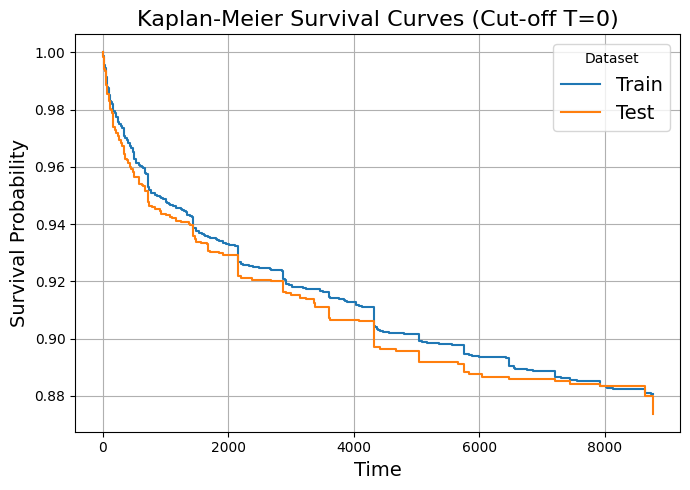

In [9]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()


## Time of Interest = 24

In [10]:
time_of_interest = 24

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


 56%|█████▌    | 5/9 [13:25<10:52, 163.01s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:07<00:00, 123.65s/it]
 67%|██████▋   | 6/9 [17:38<09:40, 193.58s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:39<00:00, 139.90s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|█

Running for seed 1234


 44%|████▍     | 4/9 [10:25<12:55, 155.14s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:34<00:00, 77.34s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [04:12<00:00, 126.18s/it]
 67%|██████▋   | 6/9 [17:26<09:35, 191.72s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:17<00:00, 128.81s/it]
 78%|███████▊  | 7/9 [21:47<07:09, 214.56s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.p

Running for seed 14


 56%|█████▌    | 5/9 [12:26<10:10, 152.58s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:54<00:00, 117.15s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [04:28<00:00, 134.11s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:52<00:00, 86.40s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:35<00:00, 107.99s/it]
100%|██████████| 9/9 [27:30<00:00, 183.34s/it]


Running for seed 74


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:33<00:00, 76.98s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:57<00:00, 118.93s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:45<00:00, 112.64s/it]
 78%|███████▊  | 7/9 [20:06<06:35, 197.88s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:23<00:00, 101.71s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:16<00:00, 98.37s/it] 
100%|██████████| 9/9 [26:50<00:00, 178.94s/it]


Running for seed 100


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:26<00:00, 73.38s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:41<00:00, 110.52s/it]
 67%|██████▋   | 6/9 [16:45<08:57, 179.29s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:42<00:00, 111.01s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [03:18<00:00, 99.28s/it] 
 89%|████████▉ | 8/9 [23:51<03:16, 196.57s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: over

In [11]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.747683,0.005969,0.072483,0.002346
1,bert-base-uncased,DeepHit,0.749742,0.014497,0.073543,0.002408
2,roberta-base,DeepSurv,0.757537,0.014125,0.070940,0.002477
3,roberta-base,DeepHit,0.760263,0.012310,0.073094,0.002407
4,deberta-v3-small,DeepSurv,0.757559,0.006189,0.071824,0.002293
5,deberta-v3-small,DeepHit,0.729874,0.019322,0.078459,0.007395
6,ModernBERT-base,DeepSurv,0.737821,0.011234,0.072987,0.002214
7,ModernBERT-base,DeepHit,0.732638,0.009591,0.074322,0.002005
8,ModernBERT-large,DeepSurv,0.665462,0.016524,0.076768,0.002940
9,ModernBERT-large,DeepHit,0.654958,0.014617,0.077926,0.003122


In [12]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.750 ± 0.014,0.074 ± 0.002,DeepHit
1,roberta-base,0.760 ± 0.012,0.073 ± 0.002,DeepHit
2,deberta-v3-small,0.758 ± 0.006,0.072 ± 0.002,DeepSurv
3,ModernBERT-base,0.738 ± 0.011,0.073 ± 0.002,DeepSurv
4,ModernBERT-large,0.665 ± 0.017,0.077 ± 0.003,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.818 ± 0.009,0.066 ± 0.002,DeepSurv
6,Llama-3.3-70B-Instruct,0.821 ± 0.011,0.068 ± 0.003,DeepHit
7,DeepSeek-R1-Distill-Llama-8B,0.809 ± 0.013,0.070 ± 0.002,DeepHit
8,Llama-3.1-8B-Instruct,0.817 ± 0.010,0.069 ± 0.002,DeepHit


Time of interest threshold: 24h
Random Seed: 100
Train: 15420 case reports, 0.93 censoring rate
Test: 3816 case reports, 0.92 censoring rate


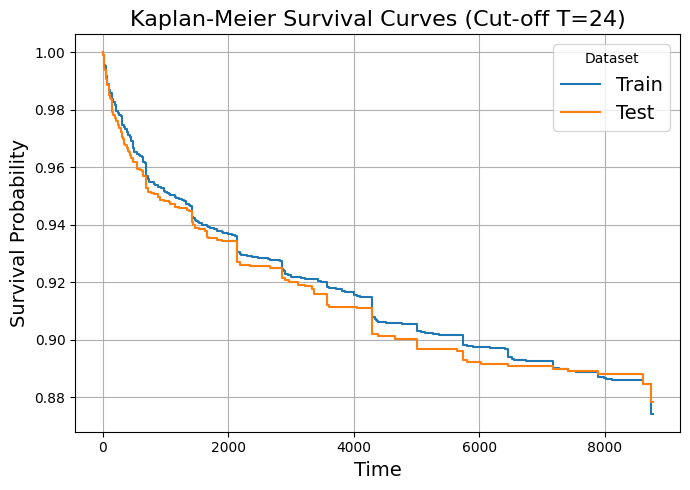

In [13]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()


## Time of Interest = 168

In [14]:
time_of_interest = 168

# Define random seeds
random_seeds = [42, 1234, 14, 74, 100]

# Store metrics across seeds
aggregated_results = defaultdict(lambda: defaultdict(list))

for random_seed in random_seeds:
    print(f"Running for seed {random_seed}")
    for model_name in tqdm(model_names):
        data_file = f'tts/{embeddings_folder}/survival_data_embeddings_{model_name}_t{time_of_interest}.pkl'

        with open(data_file, 'rb') as f:
            data_dict = pickle.load(f)

        pmc_ids = list(data_dict.keys())
        random.seed(random_seed)
        test_pmc_ids = set(random.sample(pmc_ids, int(0.2 * len(pmc_ids))))

        train_data = {k: v for k, v in data_dict.items() if k not in test_pmc_ids}
        test_data = {k: data_dict[k] for k in test_pmc_ids}

        X_train = np.array([train_data[cr_id]['embedding'] for cr_id in train_data])
        Y_train = np.array([train_data[cr_id]['label'] for cr_id in train_data])
        Y_train[Y_train[:, 0] >= right_censoring_time] = [right_censoring_time, 0]

        X_test = np.array([test_data[cr_id]['embedding'] for cr_id in test_data])
        Y_test = np.array([test_data[cr_id]['label'] for cr_id in test_data])
        Y_test[Y_test[:, 0] > right_censoring_time] = [right_censoring_time, 0]

        X_train = X_train[Y_train[:, 0] > 0]
        Y_train = Y_train[Y_train[:, 0] > 0]
        X_test = X_test[Y_test[:, 0] > 0]
        Y_test = Y_test[Y_test[:, 0] > 0]

        X_tr, X_val, Y_tr, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=random_seed)

        rf_grid = {
            'n_estimators': [20, 50, 100],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 5]
        }
        deep_grid = {
            'num_nodes': [64, 128, 256, 512, 1024, 2048, 4096],
            'dropout': [0.1, 0.5]
        }

        for survival_model in tqdm(survival_models, desc=f"Training Survival Models for {model_name}"):
            best_model = None
            best_val_metric = -np.inf
            best_params = None

            if survival_model == 'RandomSurvivalForest':
                hp_combinations = product(*rf_grid.values())
                hp_keys = list(rf_grid.keys())
            else:
                hp_combinations = product(*deep_grid.values())
                hp_keys = list(deep_grid.keys())

            for hp_vals in hp_combinations:
                hyperparams = dict(zip(hp_keys, hp_vals))
                if survival_model in ['DeepSurv', 'DeepHit']:
                    hyperparams['epochs'] = 2000
                    hyperparams['batch_size'] = 256 if len(X_tr) % 256 != 1 else 250

                model = SurvivalModel(
                    survival_model,
                    hyperparams,
                    extrapolate_median=task_setup_dict["extrapolate_median"],
                    random_seed=random_seed
                )
                model.fit(X_tr, Y_tr)
                val_metrics = model.evaluate(X_val, Y_val)
                val_score = val_metrics['concordance_td']

                if val_score > best_val_metric:
                    best_val_metric = val_score
                    best_model = model
                    best_params = hyperparams

            test_metrics = best_model.evaluate(X_test, Y_test)
            aggregated_results[model_name][survival_model].append(test_metrics)

# Aggregate results
final_results = {}
for model_name in aggregated_results:
    final_results[model_name] = {}
    for surv_model, metrics_list in aggregated_results[model_name].items():
        concordance_vals = [m['concordance_td'] for m in metrics_list]
        ibs_vals = [m['integrated_brier_score'] for m in metrics_list]
        final_results[model_name][surv_model] = {
            'concordance_td_mean': np.mean(concordance_vals),
            'concordance_td_std': np.std(concordance_vals),
            'integrated_brier_score_mean': np.mean(ibs_vals),
            'integrated_brier_score_std': np.std(ibs_vals)
        }

# Convert to DataFrame for visualization
df_summary = []
for model_name in final_results:
    for surv_model in final_results[model_name]:
        row = {
            'embedding_model': model_name,
            'survival_model': surv_model,
            **final_results[model_name][surv_model]
        }
        df_summary.append(row)
df_summary = pd.DataFrame(df_summary)

# Save
with open(f'tts_survival_results_t{time_of_interest}_{embeddings_folder}_5seeds.pkl', 'wb') as f:
    pickle.dump(df_summary, f)

Running for seed 42


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [01:58<00:00, 59.11s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:32<00:00, 106.26s/it]
 67%|██████▋   | 6/9 [14:43<08:12, 164.13s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:53<00:00, 116.53s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:57<00:00, 88.55s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [02:15<00:00, 67.79s/it]
100%|██████████| 9/9 [24:00<00:00, 

Running for seed 1234


 56%|█████▌    | 5/9 [11:28<09:08, 137.01s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:19<00:00, 99.93s/it] 
 67%|██████▋   | 6/9 [14:52<07:59, 159.74s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:51<00:00, 115.81s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|█

Running for seed 14


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [01:56<00:00, 58.46s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [02:55<00:00, 87.50s/it]
 67%|██████▋   | 6/9 [13:54<07:21, 147.30s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.pred

Running for seed 74


 56%|█████▌    | 5/9 [10:27<08:13, 123.31s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [02:58<00:00, 89.28s/it]
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:13<00:00, 96.98s/it] 
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:23<00:00, 71.74s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [02:22<00:00, 71.34s/it]
100%|██████████| 9/9 [21:38<00:00, 144.28s/it]


Running for seed 100


Training Survival Models for ModernBERT-large: 100%|██████████| 2/2 [02:25<00:00, 72.59s/it]
Training Survival Models for DeepSeek-R1-Distill-Llama-70B: 100%|██████████| 2/2 [03:15<00:00, 97.77s/it] 
 67%|██████▋   | 6/9 [15:33<08:19, 166.48s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:247: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)
Training Survival Models for Llama-3.3-70B-Instruct: 100%|██████████| 2/2 [03:19<00:00, 99.53s/it] 
 78%|███████▊  | 7/9 [18:56<05:56, 178.48s/it]/mnt/c/Research/tts-forecasting/Shahriar/pycox/models/cox.py:227: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
Training Survival Models for DeepSeek-R1-Distill-Llama-8B: 100%|██████████| 2/2 [02:51<00:00, 85.66s/it]
Training Survival Models for Llama-3.1-8B-Instruct: 100%|██████████| 2/2 [03:03<00:00, 

In [15]:
df_summary

,embedding_model,survival_model,concordance_td_mean,concordance_td_std,integrated_brier_score_mean,integrated_brier_score_std
0,bert-base-uncased,DeepSurv,0.746685,0.009533,0.063481,0.002730
1,bert-base-uncased,DeepHit,0.743904,0.009176,0.063746,0.003214
2,roberta-base,DeepSurv,0.762199,0.010864,0.061981,0.002530
3,roberta-base,DeepHit,0.760741,0.008651,0.063388,0.003420
4,deberta-v3-small,DeepSurv,0.751049,0.006403,0.062858,0.002618
5,deberta-v3-small,DeepHit,0.732763,0.011519,0.065127,0.002452
6,ModernBERT-base,DeepSurv,0.728713,0.009486,0.064236,0.002427
7,ModernBERT-base,DeepHit,0.725481,0.012823,0.064643,0.002382
8,ModernBERT-large,DeepSurv,0.661601,0.003301,0.066201,0.002528
9,ModernBERT-large,DeepHit,0.643115,0.010775,0.066433,0.002783


In [16]:
# Find best model (based on concordance_td_mean) per embedding model
best_rows = []
for model_name in df_summary['embedding_model'].unique():
    sub_df = df_summary[df_summary['embedding_model'] == model_name]
    best_idx = sub_df['concordance_td_mean'].idxmax()
    best_row = sub_df.loc[best_idx]
    
    # Format the output
    concordance_td = f"{best_row['concordance_td_mean']:.3f} ± {best_row['concordance_td_std']:.3f}"
    ibs = f"{best_row['integrated_brier_score_mean']:.3f} ± {best_row['integrated_brier_score_std']:.3f}"
    
    best_rows.append({
        'embedding_model': model_name,
        'concordance_td': concordance_td,
        'integrated_brier_score': ibs,
        'best_survival_model': best_row['survival_model']
    })

final_table = pd.DataFrame(best_rows)
final_table

,embedding_model,concordance_td,integrated_brier_score,best_survival_model
0,bert-base-uncased,0.747 ± 0.010,0.063 ± 0.003,DeepSurv
1,roberta-base,0.762 ± 0.011,0.062 ± 0.003,DeepSurv
2,deberta-v3-small,0.751 ± 0.006,0.063 ± 0.003,DeepSurv
3,ModernBERT-base,0.729 ± 0.009,0.064 ± 0.002,DeepSurv
4,ModernBERT-large,0.662 ± 0.003,0.066 ± 0.003,DeepSurv
5,DeepSeek-R1-Distill-Llama-70B,0.812 ± 0.014,0.059 ± 0.002,DeepSurv
6,Llama-3.3-70B-Instruct,0.822 ± 0.009,0.061 ± 0.005,DeepSurv
7,DeepSeek-R1-Distill-Llama-8B,0.809 ± 0.011,0.060 ± 0.002,DeepSurv
8,Llama-3.1-8B-Instruct,0.809 ± 0.011,0.059 ± 0.002,DeepSurv


Time of interest threshold: 168h
Random Seed: 100
Train: 13308 case reports, 0.93 censoring rate
Test: 3296 case reports, 0.93 censoring rate


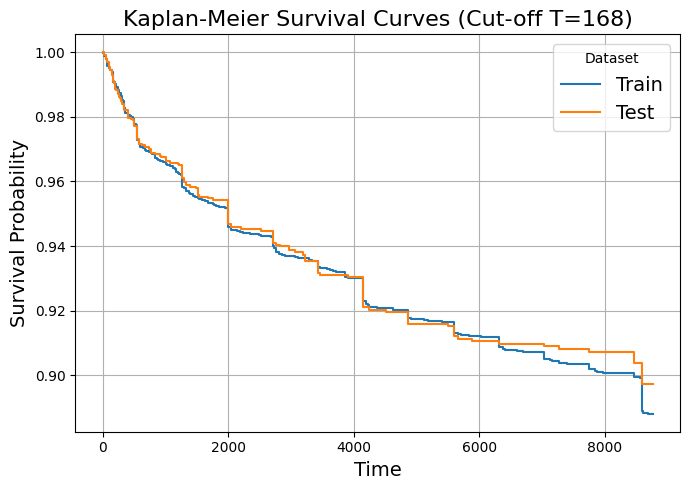

In [17]:
# Plotting Kaplan-Meier survival curves
print(f"Time of interest threshold: {time_of_interest}h")
print("Random Seed:", random_seed)
print(f"Train: {len(Y_train)} case reports, {1-np.mean(Y_train[:, 1]):.2f} censoring rate")
print(f"Test: {len(Y_test)} case reports, {1-np.mean(Y_test[:, 1]):.2f} censoring rate")

# Setup
kmf = KaplanMeierFitter()
plt.figure(figsize=(7, 5))

durations, events = Y_train[:, 0], Y_train[:, 1]
kmf.fit(durations, events, label="Train")
kmf.plot(ci_show=False)

durations, events = Y_test[:, 0], Y_test[:, 1]
kmf.fit(durations, events, label="Test")
kmf.plot(ci_show=False)


# Final touches
plt.title(f"Kaplan-Meier Survival Curves (Cut-off T={time_of_interest})", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.legend(title="Dataset", fontsize=14)
plt.tight_layout()
plt.grid('minor')
plt.show()
